<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="700" height="200" />


### <font color='navy'> Modelos no lineales para pronósticos.

**Nombres:**
- Zamarrón Álvarez, Ana Rosaura
- Castillejos Jauregui, Claudia Celeste

**Fecha:** 24 de abril del 2023.

**Expediente** :
- 736222
- 735868

**Profesor:** Oscar David Jaramillo Zuluaga.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import MSTL
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Cargamos los datos
data = pd.read_csv("traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
# El tamaño del arreglo 
data.shape

(48120, 4)

In [4]:
#Ver el tipo de dato de las variables
data.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [5]:
# Cambiar el tipo de dato de las variables necesarias
data["ID"] = data["ID"].astype("object")
data["DateTime"] = pd.to_datetime(data['DateTime'])

In [6]:
# Ver el resultado del cambio en el tipo de variable 
data.dtypes

DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                  object
dtype: object

In [7]:
# Descripción de las variables numéricas
data.describe()

,Junction,Vehicles
count,48120.000000,48120.000000
mean,2.180549,22.791334
std,0.966955,20.750063
min,1.000000,1.000000
25%,1.000000,9.000000
50%,2.000000,15.000000
75%,3.000000,29.000000
max,4.000000,180.000000


In [8]:
# Vemos los valores de la columna date+time
data["DateTime"].value_counts()

2017-06-30 23:00:00    4
2017-03-02 02:00:00    4
2017-03-02 16:00:00    4
2017-03-02 15:00:00    4
2017-03-02 14:00:00    4
                      ..
2016-05-21 19:00:00    3
2016-05-21 20:00:00    3
2016-05-21 21:00:00    3
2016-05-21 22:00:00    3
2016-08-31 00:00:00    3
Name: DateTime, Length: 14592, dtype: int64

In [9]:
# Ver los registros con esa fecha
data[data["DateTime"] == "2017-06-30 23:00:00"]

,DateTime,Junction,Vehicles,ID
14591,2017-06-30 23:00:00,1,78,20170630231
29183,2017-06-30 23:00:00,2,27,20170630232
43775,2017-06-30 23:00:00,3,39,20170630233
48119,2017-06-30 23:00:00,4,12,20170630234


In [10]:
# Ver los registros con esa fecha
data[data["DateTime"] == "2017-03-02 02:00:00"]

,DateTime,Junction,Vehicles,ID
11690,2017-03-02 02:00:00,1,50,20170302021
26282,2017-03-02 02:00:00,2,24,20170302022
40874,2017-03-02 02:00:00,3,11,20170302023
45218,2017-03-02 02:00:00,4,5,20170302024


Las fechas se repiten para cada junction. Nos quedaremos con una sola serie , la de Junction 1.

In [11]:
# Reducimos la base de datos
junction1 = data[data["Junction"] == 1]
junction1.shape

(14592, 4)

In [12]:
#Hacemos una reducción de la base de datos
timeseries = junction1[["DateTime", "Vehicles"]].set_index('DateTime')
timeseries.head()

,Vehicles
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9


Text(0.5, 1.0, 'Junction 1 Vehicles Timeserie')

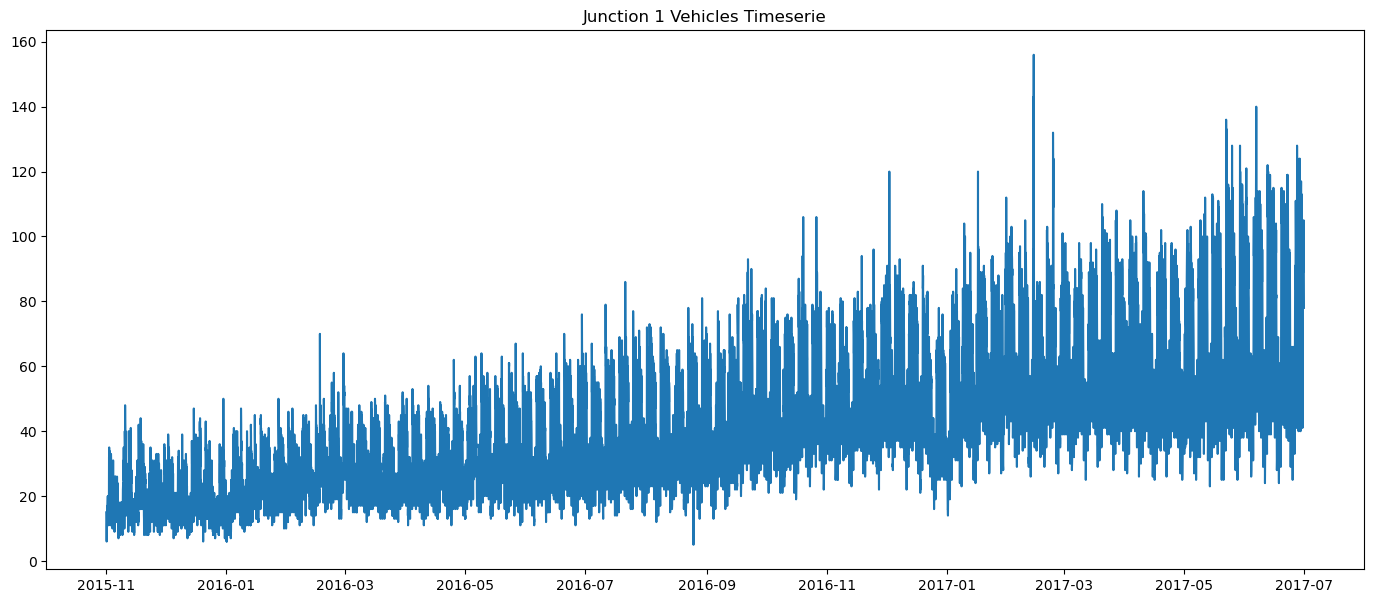

In [13]:
# Graficamos la serie de tiempo 
plt.figure(figsize=(17,7))
plt.plot(timeseries)
plt.title("Junction 1 Vehicles Timeserie")

array([[<AxesSubplot:title={'center':'Vehicles'}>]], dtype=object)

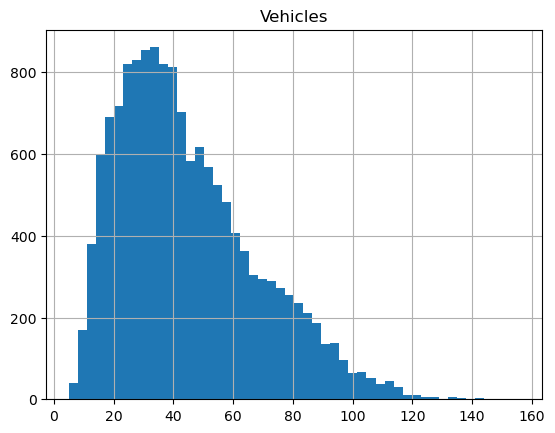

In [14]:
# Histogramas
timeseries.hist(bins=50)

<AxesSubplot:>

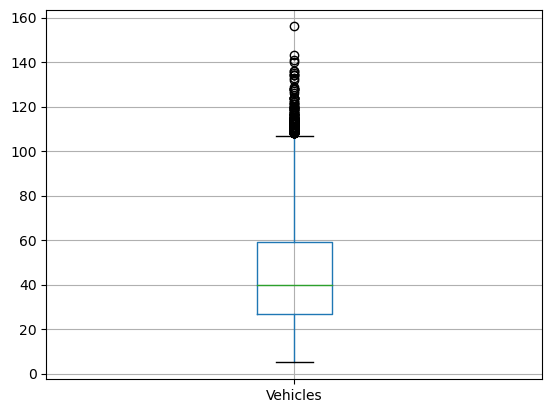

In [15]:
# Distribución de las variables numéricas
timeseries.boxplot()

Tenemos varios outliers pero no consideramos que haga falta eliminarlas o tratarlas.

In [16]:
# Descripción de las variables numéricas
timeseries.describe()

,Vehicles
count,14592.000000
mean,45.052906
std,23.008345
min,5.000000
25%,27.000000
50%,40.000000
75%,59.000000
max,156.000000


In [17]:
#Sample de un año 
start_date = '2015-01-01'
end_date = '2016-01-01'


timeseriesML = timeseries[start_date:end_date]

<AxesSubplot:>

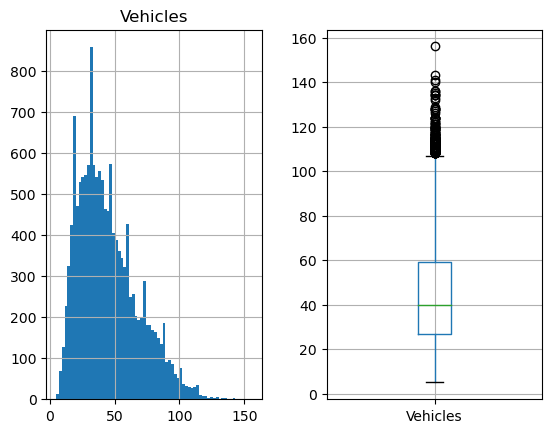

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
timeseries.hist(bins=70, ax=ax[0])
timeseries.boxplot(ax=ax[1])

En este gráfico nos muestra que tenemos unos cuantos outliers y su distribución esta ligeramente sesgada

## Modelos lineales

In [19]:
class LinearForecast:
    def __init__(self, data):
        self.data = data

    def adf_test(self):
        """
        Método que calcula el ADF Test y determina si los datos ingresados son estacionarios o no.
        :return:
        """
        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(self.data, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)

        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

        # Graficar ACF y PACF
    def plot_acf_pacf(self, kwargs=dict()):
        
        f = plt.figure(figsize=(8,5))
        ax1 = f.add_subplot(121)
        plot_acf(self.data, zero=False, ax=ax1, lags=7, **kwargs)
        ax2 = f.add_subplot(122)
        plot_pacf(self.data, zero=False, ax=ax2, lags=np.arange(7), method='ols', **kwargs)
        plt.show()

    def descomposicion(self):
        """
        Método que grafica la descomposición de la serie.
        :return: res2
        """
        data1 = self.data.copy()
        periods_seasonality = (6, 12)

        stl_kwargs = {"seasonal_deg": 0}
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()

        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(17, 8))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()

        return res2

    def split_dataset(self, test_size=0.3):
        """
        Función que se encarga de dividir la data ingresada en datos de entrenamiento y prueba.
        :param test_size: proporción de los datos de prueba
        :param data: Data con la información de la serie de tiempo a analizar.
        """

        train_data, test_data = train_test_split(self.data, test_size=test_size, random_state=0, shuffle=False)

        return train_data, test_data

    @staticmethod
    def evaluate_forecasts(actual, predicted):
        """
        Función que se encargará de calcular las métricas de error. (MSE, RMSE, MAD, MAPE)
        :param actual: Valor actual de la serie de tiempo que se desea predecir.
        :param predicted: Valor predecido por el modelo ajustado.
        """
        mse = mean_squared_error(actual, predicted)
        rmse = mean_squared_error(actual, predicted, squared=True)
        mad = mean_absolute_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)

        return mse, rmse, mad, mape

In [20]:
# Separamos los datos en entrenamiento y prueba (train = 70 y test = 30)
lf = LinearForecast(timeseriesML)
train, test = lf.split_dataset()

In [21]:
test.head()

,Vehicles
DateTime,
2015-12-14 09:00:00,18
2015-12-14 10:00:00,31
2015-12-14 11:00:00,37
2015-12-14 12:00:00,31
2015-12-14 13:00:00,30


<AxesSubplot:xlabel='DateTime'>

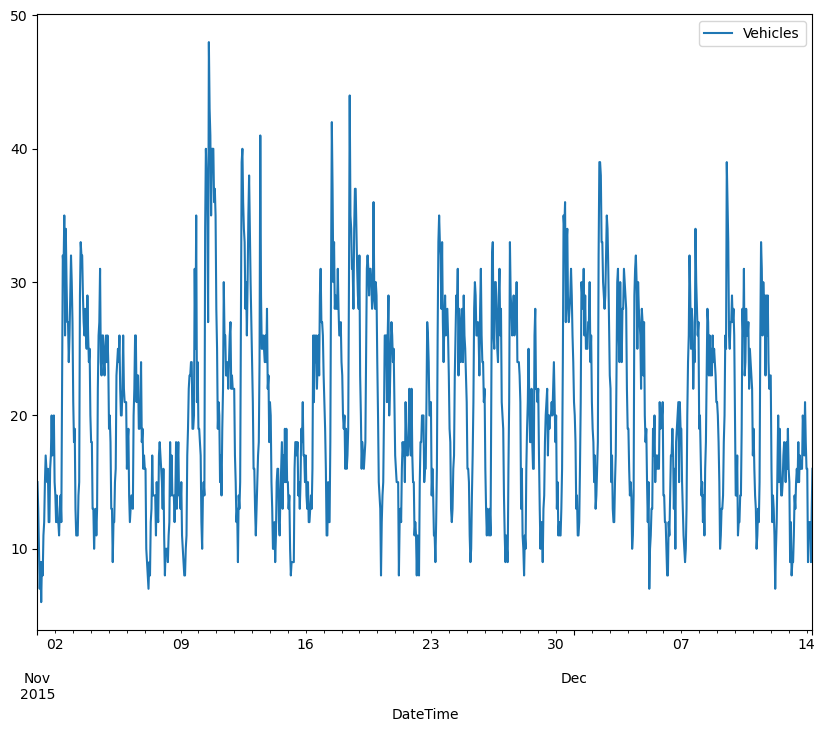

In [22]:
# Vemos la serie de tiempo para train
train.plot(figsize=(10, 8))

In [23]:
#Evaluamos el Sesgo de vehicles
skewness = round(train.skew(),2)
skewness = skewness.to_frame()
skewness = skewness.rename(columns={0: "value"}) 

def f(x):
    if x['value'] < -1 or x['value'] > 1: return 'Highly Skewed'
    elif (x['value']<=0 and x['value']>=-0.5) or (x['value'] >=0 and x['value']<=0.5):
        return 'Symmetric distribution'
    else: return 'Moderately skewed'
    
skewness['skewness'] = skewness.apply(f, axis=1)

skewness

,value,skewness
Vehicles,0.45,Symmetric distribution


La serie de tiempo tiene una sesgo moderado por lo tanto le vamos a hacer una transformación 

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [25]:
#Transformamos la variable vehicles2 
train["Vehicles2"] = scaler.fit_transform(train)

In [26]:
#Transformamos la variable vehicles2
test["Vehicles2"] = scaler.fit_transform(test)

<AxesSubplot:xlabel='DateTime'>

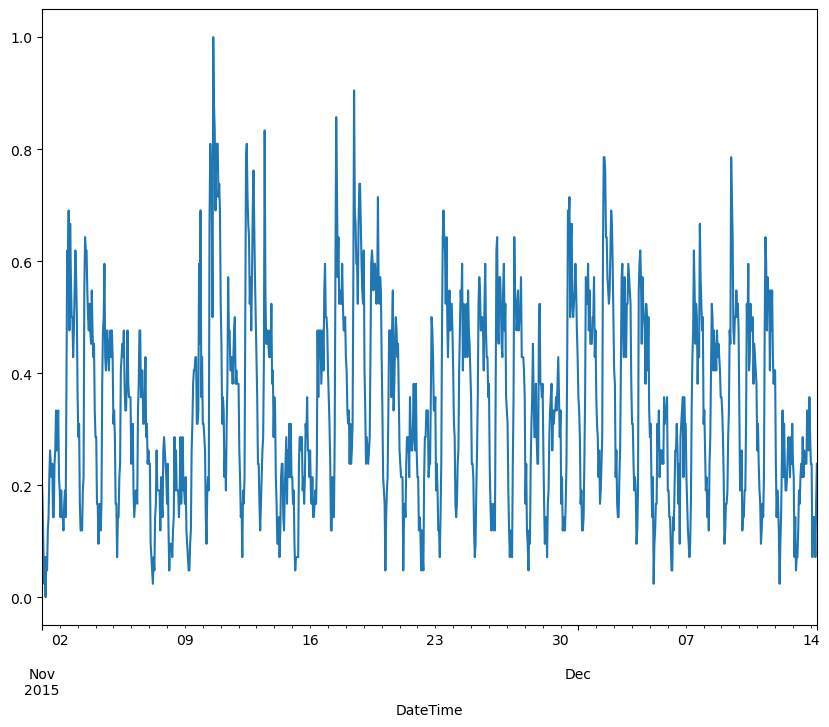

In [27]:
# Mostramos la serie de tiempo de los datos de entrenamiento para ver que le conviene de transformación
train["Vehicles2"].plot(figsize=(10, 8))

C:\Users\Castillejos\AppData\Local\Temp\ipykernel_20240\3959528424.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train.hist(bins=70, ax=ax[0])


<AxesSubplot:>

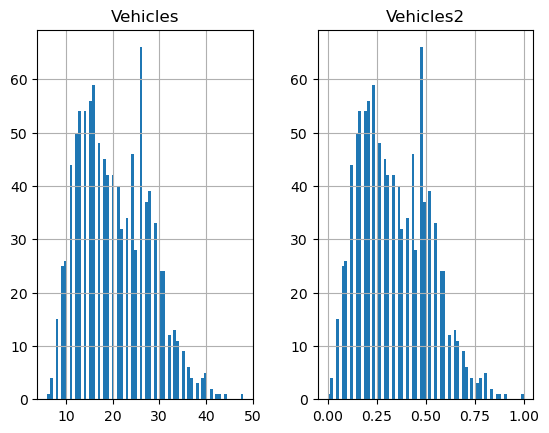

In [28]:
# Obtenemos el histograma para ver los datos. 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
train.hist(bins=70, ax=ax[0])
train.boxplot(ax=ax[1])

<AxesSubplot:xlabel='DateTime'>

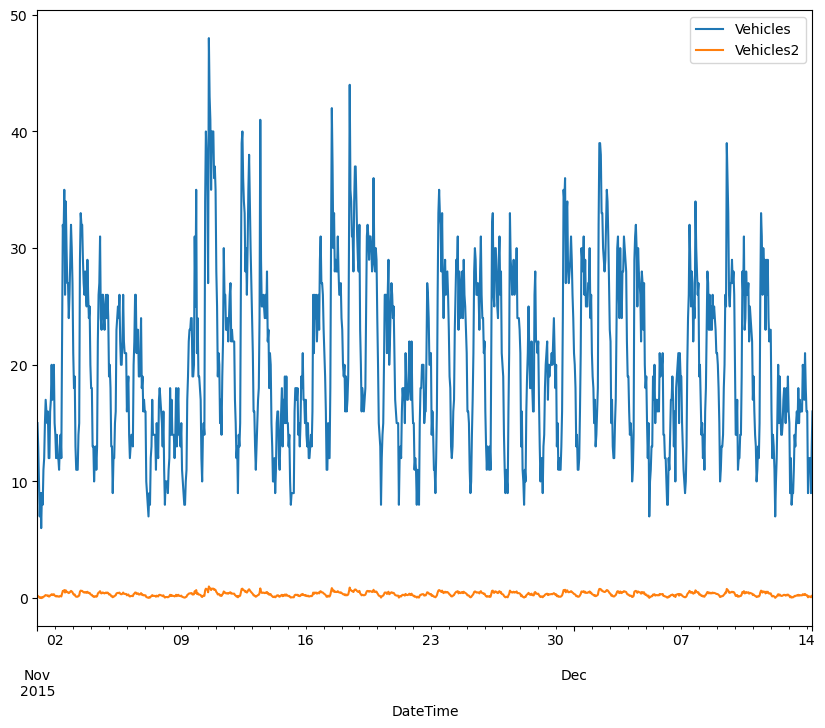

In [29]:
# La serie de tiempo original de train 
train.plot(figsize=(10, 8))

In [30]:
lf = LinearForecast(train["Vehicles2"])
lf.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                   -2.383458
p-value                           0.146460
#Lags Used                       22.000000
Number of Observations Used    1018.000000
Critical Value (1%)              -3.436790
Critical Value (5%)              -2.864383
Critical Value (10%)             -2.568284
dtype: float64
Non-stationary


Los datos son estacionarios despúes de la transformación, esto significa que los datos tienen una media, autocorrelación y varianza constantes. 

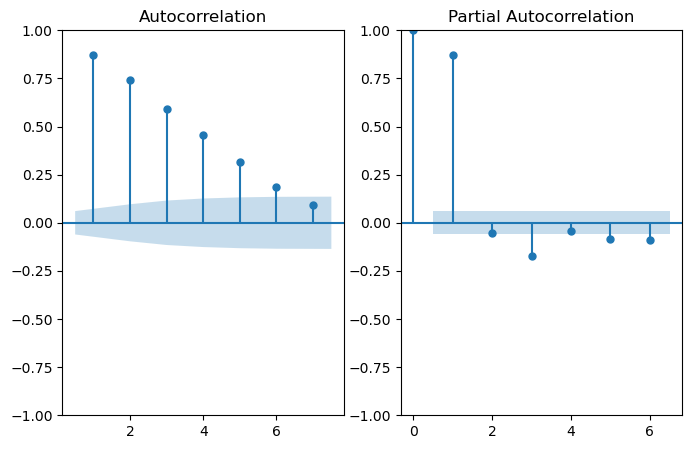

In [31]:
lf.plot_acf_pacf()

Esta gráfica nos permite ver si la serie de tiempo tiene autocorrelación y autocorrelación parcial con ella puedes detrminar la q y p. Para este caso, si tienen autocorrelación el tiempo de insvestigación.

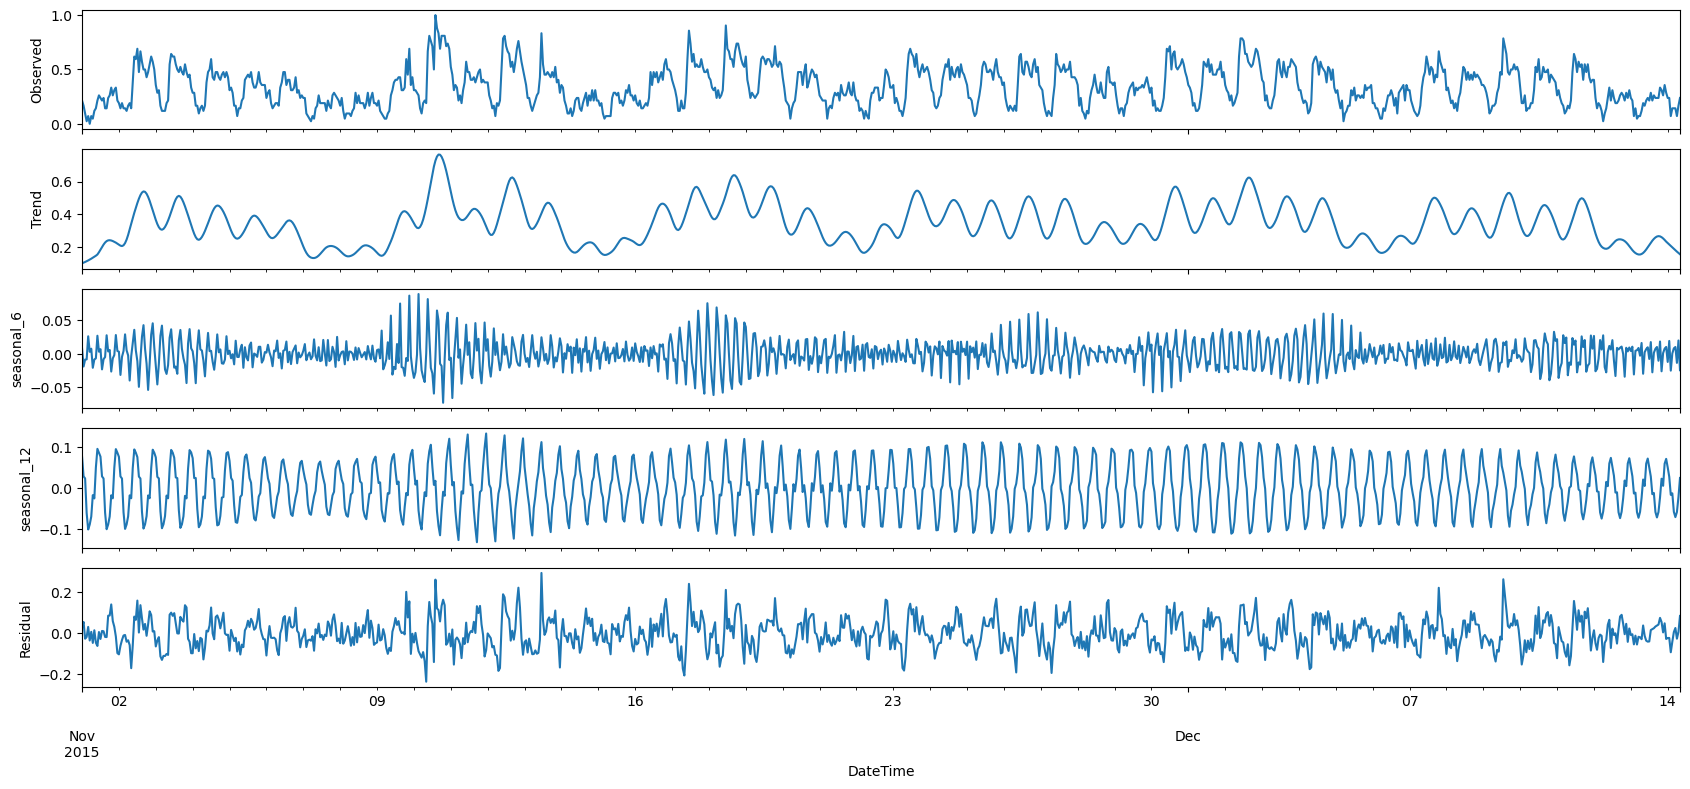

In [32]:
#Vemos la descomposición de los datos
des = lf.descomposicion()

Este gráfico de descomposion nos ayuda a entender mejor la serie de tiempo y analizarla con más entendimiento. Cuando analizamos la serie de tiempo tomada a 12 meses podemos ver que cumple con un ciclo repetitivo por lo tanto podriamos inferir que si tiene estacionalidad.

In [33]:
seasonality_6 = des.seasonal['seasonal_6']
LinearForecast(seasonality_6).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -21.796275
p-value                           0.000000
#Lags Used                       22.000000
Number of Observations Used    1018.000000
Critical Value (1%)              -3.436790
Critical Value (5%)              -2.864383
Critical Value (10%)             -2.568284
dtype: float64
Stationary


In [34]:
seasonality_12 = des.seasonal['seasonal_12']
LinearForecast(seasonality_12).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -1.630912e+01
p-value                        3.209245e-29
#Lags Used                     2.100000e+01
Number of Observations Used    1.019000e+03
Critical Value (1%)           -3.436784e+00
Critical Value (5%)           -2.864381e+00
Critical Value (10%)          -2.568282e+00
dtype: float64
Stationary


> **Conclusión** Como el nivel de significacia es de 3.19, se puede rechazar la hipótesis nula. Por lo tanto, la serie es estacionaria en ambos casos.

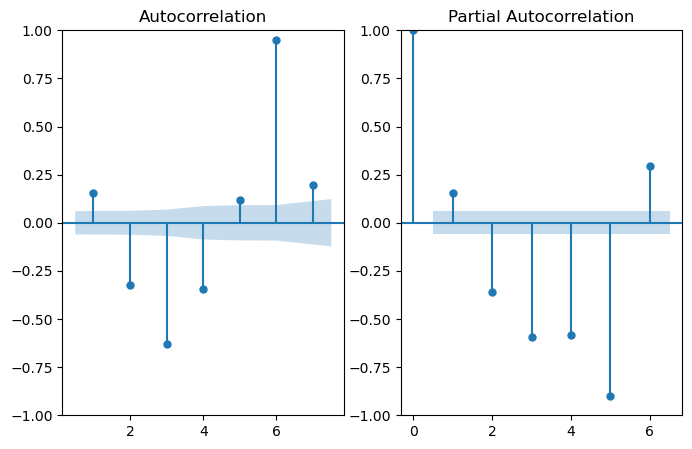

In [35]:
# Sacamos el de las 6 meses
lf12 = LinearForecast(seasonality_6)
lf12.plot_acf_pacf()

Los parámetros que evaluo dentro de la serie de tiempo son: 
 * p = 0 - 2
 * d = 0
 * q = 0 - 2 
 
 * P = 0 - 1
 * D = 0 
 * Q = 0 - 1

In [36]:
import itertools

# Posibles valores en lo que pueden variar los parámetros de un SARIMAX
# Parte no estacional
p = [0, 1, 2]
d = [0]
q = [0, 1, 2]
# Parte estacional
P = [0, 1]
D = [0]
Q = [0, 1]
# Tipo de tendencia
t = ['n', 'c', 't', 'ct']

#sarimax_params
param_no_estacionales = list(itertools.product(p, d, q))
param_estacionales = [(x[0], x[1], x[2], 6) for x in list(itertools.product(P, D, Q))]
sarimax_params = list(itertools.product(param_no_estacionales, param_estacionales, t))
sarimax_params

[((0, 0, 0), (0, 0, 0, 6), 'n'),
 ((0, 0, 0), (0, 0, 0, 6), 'c'),
 ((0, 0, 0), (0, 0, 0, 6), 't'),
 ((0, 0, 0), (0, 0, 0, 6), 'ct'),
 ((0, 0, 0), (0, 0, 1, 6), 'n'),
 ((0, 0, 0), (0, 0, 1, 6), 'c'),
 ((0, 0, 0), (0, 0, 1, 6), 't'),
 ((0, 0, 0), (0, 0, 1, 6), 'ct'),
 ((0, 0, 0), (1, 0, 0, 6), 'n'),
 ((0, 0, 0), (1, 0, 0, 6), 'c'),
 ((0, 0, 0), (1, 0, 0, 6), 't'),
 ((0, 0, 0), (1, 0, 0, 6), 'ct'),
 ((0, 0, 0), (1, 0, 1, 6), 'n'),
 ((0, 0, 0), (1, 0, 1, 6), 'c'),
 ((0, 0, 0), (1, 0, 1, 6), 't'),
 ((0, 0, 0), (1, 0, 1, 6), 'ct'),
 ((0, 0, 1), (0, 0, 0, 6), 'n'),
 ((0, 0, 1), (0, 0, 0, 6), 'c'),
 ((0, 0, 1), (0, 0, 0, 6), 't'),
 ((0, 0, 1), (0, 0, 0, 6), 'ct'),
 ((0, 0, 1), (0, 0, 1, 6), 'n'),
 ((0, 0, 1), (0, 0, 1, 6), 'c'),
 ((0, 0, 1), (0, 0, 1, 6), 't'),
 ((0, 0, 1), (0, 0, 1, 6), 'ct'),
 ((0, 0, 1), (1, 0, 0, 6), 'n'),
 ((0, 0, 1), (1, 0, 0, 6), 'c'),
 ((0, 0, 1), (1, 0, 0, 6), 't'),
 ((0, 0, 1), (1, 0, 0, 6), 'ct'),
 ((0, 0, 1), (1, 0, 1, 6), 'n'),
 ((0, 0, 1), (1, 0, 1, 6), 'c'),
 ((

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
n = 5
resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index=np.arange(0, 11))

i = 0
for par_no_esta, par_esta, trend in sarimax_params:
    mod = SARIMAX(
        endog=seasonality_6,
        trend=trend,
        order=par_no_esta,
        seasonal_order=par_esta
    )
    results = mod.fit(disp=False)

    resultados.loc[i, 'params'] = str((par_no_esta, par_esta, trend))
    resultados.loc[i, 'AIC'] = results.aic
    resultados.loc[i, 'BIC'] = results.bic
    resultados.loc[i, 'LLF'] = results.llf
    i += 1

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\b

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packag

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\

In [38]:
resultados.sort_values(by=['AIC'], ascending=True)

,params,AIC,BIC,LLF
140,"((2, 0, 2), (1, 0, 1, 6), 'n')",-9314.000779,-9279.36522,4664.00039
124,"((2, 0, 1), (1, 0, 1, 6), 'n')",-9249.207947,-9219.520324,4630.603973
141,"((2, 0, 2), (1, 0, 1, 6), 'c')",-9125.537677,-9085.954181,4570.768839
125,"((2, 0, 1), (1, 0, 1, 6), 'c')",-9113.203726,-9078.568167,4563.601863
92,"((1, 0, 2), (1, 0, 1, 6), 'n')",-9079.085629,-9049.398006,4545.542814
...,...,...,...,...
119,"((2, 0, 1), (0, 0, 1, 6), 'ct')",-4826.954212,-4792.318653,2420.477106
82,"((1, 0, 2), (0, 0, 0, 6), 't')",-3277.75256,-3253.012875,1643.87628
83,"((1, 0, 2), (0, 0, 0, 6), 'ct')",-3275.759784,-3246.072162,1643.879892
86,"((1, 0, 2), (0, 0, 1, 6), 't')",-3275.75256,-3246.064937,1643.87628


Los mejores 5 modelos son:

    *  (2, 0, 2), (1, 0, 1, 6) 'n'
    *  (2, 0, 1), (1, 0, 1, 6) 'n'
    *  (2, 0, 2), (1, 0, 1, 6), 'c'
    *  (2, 0, 1), (1, 0, 1, 6), 'c'
    *  (1, 0, 2), (1, 0, 1, 6), 'n'

In [47]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(train["Vehicles2"],order=(2, 0, 2),seasonal_order=(1,0,1,6))
results=model.fit()

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


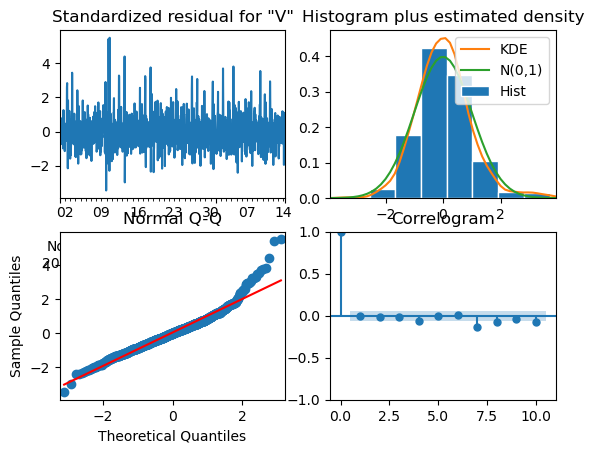

In [48]:
#Gráfico de los diagnósticos para los residuos
results.plot_diagnostics();

Los residuos parecen ser normales por que la distribución se parece a la normal, por la gráfica del correlogram se puede ver que los residuos no estan correlacionados lo cual indica que el modelo es bueno.

In [49]:
model2=sm.tsa.statespace.SARIMAX(train["Vehicles2"],order=(2, 0, 1),seasonal_order=(1,0,1,6))
results2=model2.fit()

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\

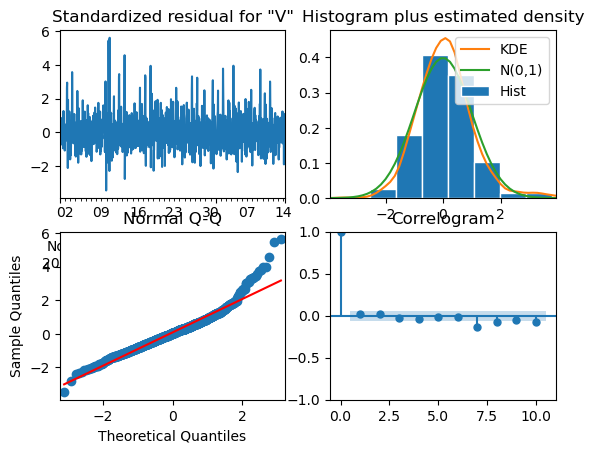

In [50]:
#Gráfico de los diagnósticos para los residuos
results2.plot_diagnostics();

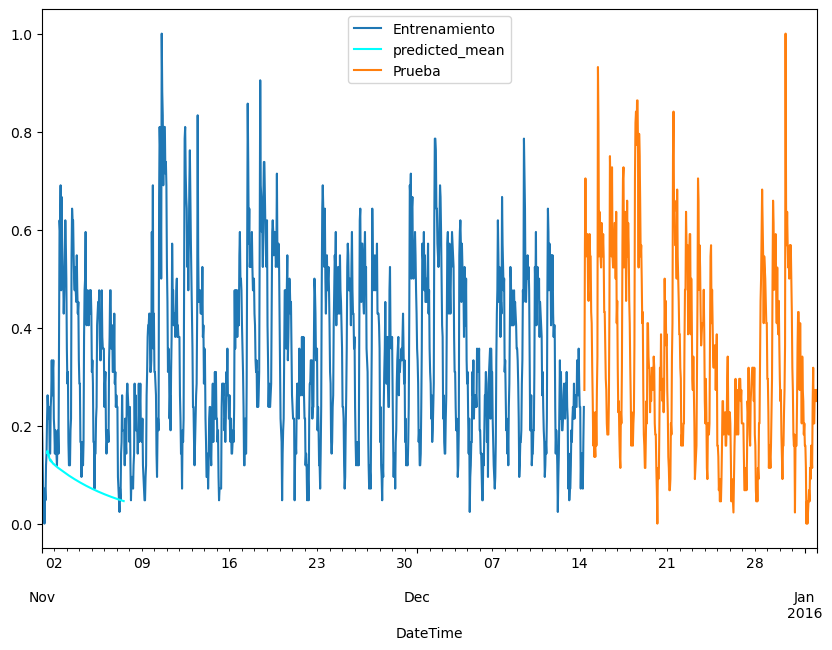

In [51]:
# Predicción
model = results.predict(start=10, end=157 , dynamic=True).to_frame()
ax = train["Vehicles2"].plot(label="Entrenamiento", figsize=(10,7))
model.plot(ax=ax, color="cyan")
ax = test["Vehicles2"].plot(ax=ax, label="Prueba")
ax.legend()

In [52]:
# Hacemos el Autoarima
lf.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                   -2.383458
p-value                           0.146460
#Lags Used                       22.000000
Number of Observations Used    1018.000000
Critical Value (1%)              -3.436790
Critical Value (5%)              -2.864383
Critical Value (10%)             -2.568284
dtype: float64
Non-stationary


In [53]:
from pmdarima.arima import auto_arima
model3 = auto_arima(train["Vehicles2"],
                             seasonal=True, m=12, max_p=5, max_q=2, max_d=1, max_P=1, max_D=1, max_Q=1,
                             stationary=False)
prediction = model3.predict(n_periods=test.shape[0])

prediction

2015-12-14 09:00:00    0.273240
2015-12-14 10:00:00    0.306844
2015-12-14 11:00:00    0.331601
2015-12-14 12:00:00    0.349484
2015-12-14 13:00:00    0.361093
                         ...   
2016-01-01 19:00:00    0.341647
2016-01-01 20:00:00    0.341647
2016-01-01 21:00:00    0.341647
2016-01-01 22:00:00    0.341647
2016-01-01 23:00:00    0.341647
Freq: H, Length: 447, dtype: float64

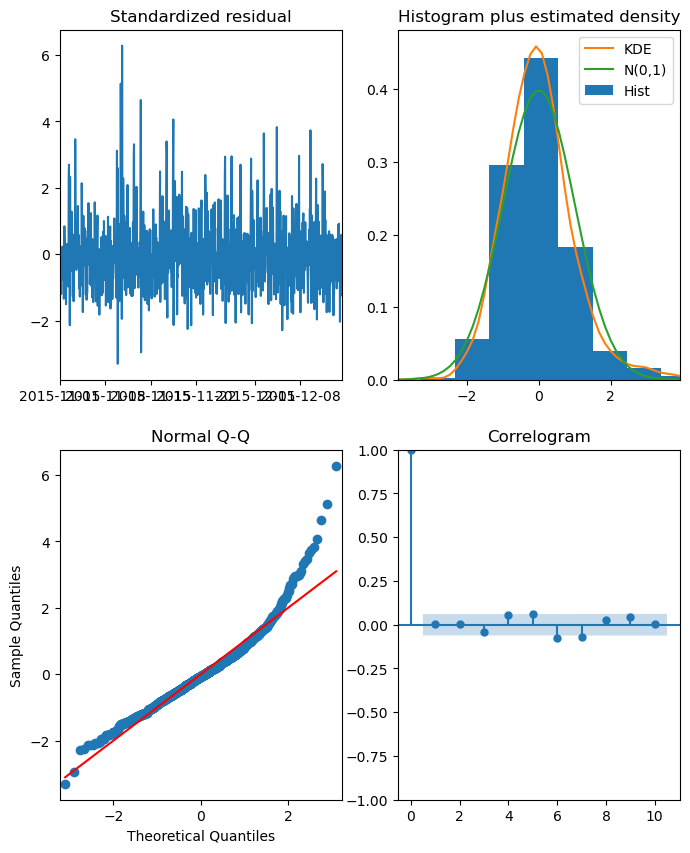

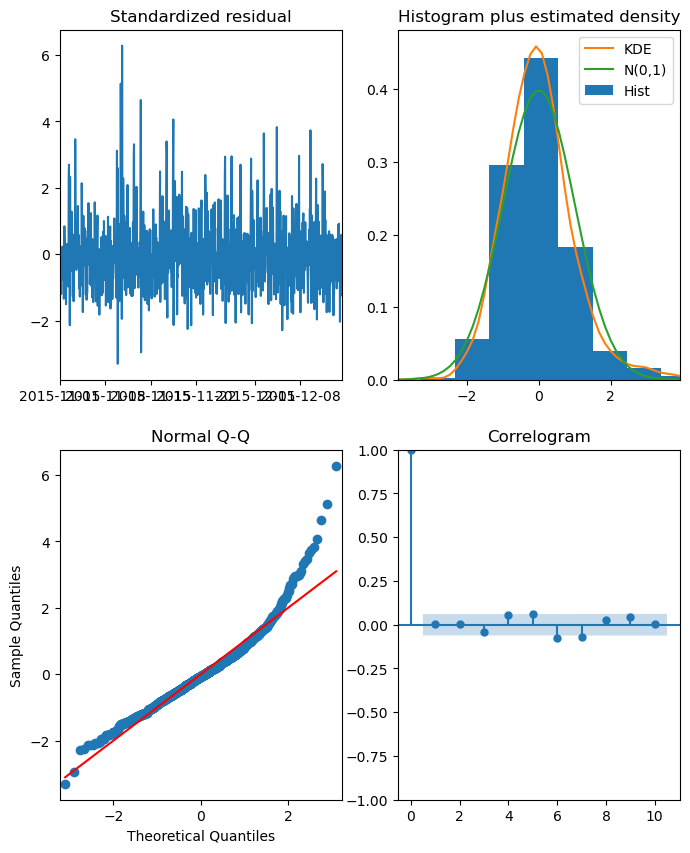

In [54]:
model3.plot_diagnostics(figsize=(8,10))

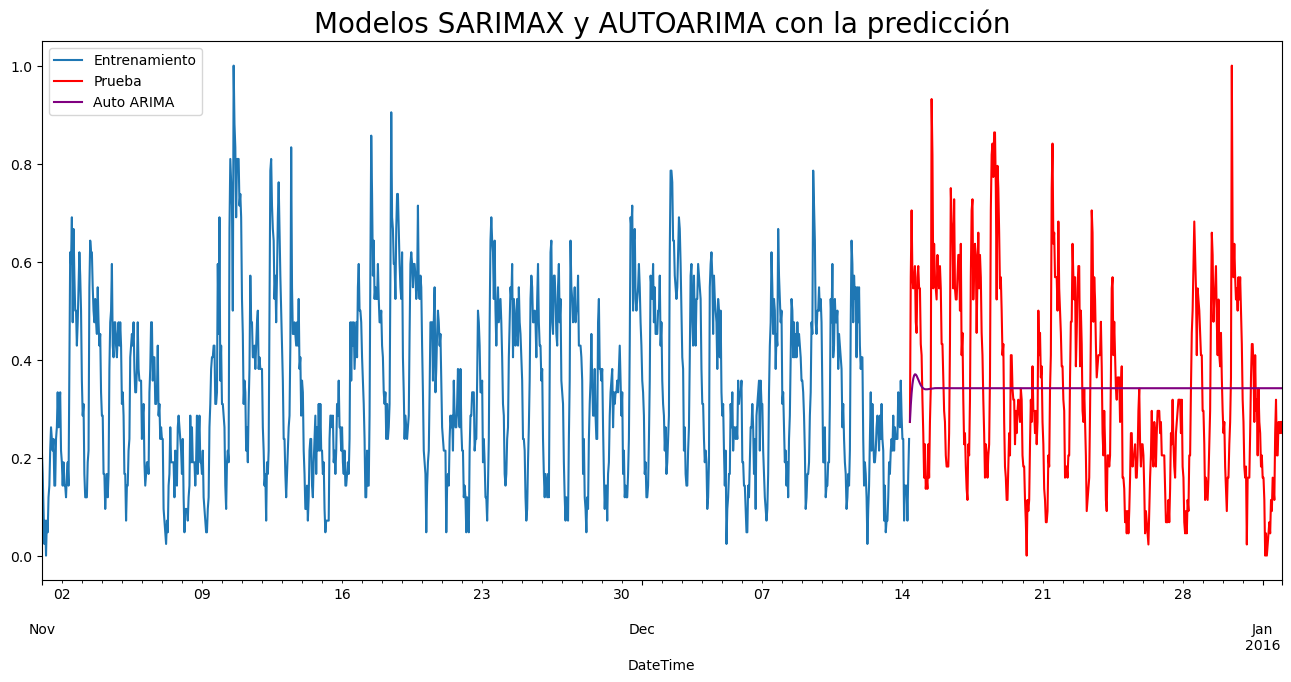

In [55]:
ax = train["Vehicles2"].plot(label="Entrenamiento", figsize=(16,7))
test["Vehicles2"].plot(ax=ax, label="Prueba", color="red")
prediction.plot(ax=ax, label="Auto ARIMA", color="purple")
plt.title("Modelos SARIMAX y AUTOARIMA con la predicción", fontsize=20)
ax.legend()